In [1]:
!git clone https://github.com/matthewachan/hyperdm.git
%cd hyperdm

Cloning into 'hyperdm'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 79 (delta 25), reused 45 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (79/79), 679.49 KiB | 2.19 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/hyperdm


# Define CDRM

In [2]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from data.toy import ToyDataset
from matplotlib.colors import LinearSegmentedColormap

class CDRMNet(nn.Module):
    def __init__(self, hidden_dims=[64, 128, 64]):
        super().__init__()

        layers = []
        input_dim = 2  # (x, y) pairs

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.SiLU(),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(0.1)
            ])
            input_dim = hidden_dim

        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, clip_min=1e-6, clip_max=1-1e-6):
        inputs = th.cat([x, y], dim=-1)
        raw_output = self.net(inputs)
        return th.clamp(th.sigmoid(raw_output), clip_min, clip_max)

class CDRM:
    def __init__(self, model, device, langevin_steps=10, langevin_step_size=0.1,
                 noise_scale=0.01, num_neg_samples=32,
                 inference_samples=100, inference_step_size=0.01):
        self.model = model.to(device)
        self.device = device
        # Training parameters
        self.langevin_steps = langevin_steps
        self.langevin_step_size = langevin_step_size
        self.noise_scale = noise_scale
        self.num_neg_samples = num_neg_samples
        # Inference parameters
        self.inference_samples = inference_samples
        self.inference_step_size = inference_step_size
        self.optimizer = th.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    def langevin_sampling(self, batch_size):
        """Generate negative samples using Langevin dynamics"""
        # Initialize random samples
        x_neg = th.rand(batch_size * self.num_neg_samples, 1, device=self.device) * 2 - 1  # [-1, 1]
        y_neg = th.rand(batch_size * self.num_neg_samples, 1, device=self.device) * 4 - 2  # [-2, 2]

        # Perform Langevin dynamics
        for step in range(self.langevin_steps):
            x_neg.requires_grad_(True)
            y_neg.requires_grad_(True)

            # Get density
            density = self.model(x_neg, y_neg)

            # Compute gradients
            grad_x, grad_y = th.autograd.grad(density.sum(), [x_neg, y_neg])

            # Update samples using gradients and add noise
            x_noise = th.randn_like(x_neg) * self.noise_scale
            y_noise = th.randn_like(y_neg) * self.noise_scale

            with th.no_grad():
                x_neg = x_neg + self.langevin_step_size * grad_x + x_noise
                y_neg = y_neg + self.langevin_step_size * grad_y + y_noise

                # Clip to valid range
                x_neg.clamp_(-1, 1)
                y_neg.clamp_(-2, 2)

        return x_neg.detach(), y_neg.detach()

    def train_step(self, x, y):
        self.model.train()
        self.optimizer.zero_grad()

        batch_size = x.size(0)

        # Generate positive samples (actual data points)
        pos_density = self.model(x, y)

        # Generate negative samples using Langevin dynamics
        x_neg, y_neg = self.langevin_sampling(batch_size)
        neg_density = self.model(x_neg, y_neg)

        # Contrastive loss
        pos_loss = -th.log(pos_density + 1e-6).mean()
        neg_loss = -th.log(1 - neg_density + 1e-6).mean()

        loss = pos_loss + neg_loss

        loss.backward()
        th.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item(), pos_density.mean().item(), neg_density.mean().item()

# Define Prediction Function (Langevin Sampling Inference Procedure)

In [46]:
def langevin_dynamics_step(model, y_samples, x_current, step_size=0.01, noise_std=0.01):
    """
    Perform one step of Langevin dynamics sampling.
    Note: model expects inputs in (y, x) order even though x is the condition
    """
    y_samples = y_samples.detach().clone().requires_grad_(True)

    # Note the order: (y_samples, x_expanded) instead of (x_expanded, y_samples)
    x_expanded = x_current.expand(y_samples.size(0), -1)
    density = model(y_samples, x_expanded)

    log_density = th.log(density + 1e-6)
    grad = th.autograd.grad(log_density.sum(), y_samples, create_graph=False)[0]

    with th.no_grad():
        noise = th.randn_like(y_samples) * noise_std
        y_samples = y_samples + step_size * grad + noise

    return y_samples, density

def predict(model, x, y_range=(-1.10, 1.10), num_samples=100, num_steps=50,
           alpha=0.5, step_size=0.01, noise_std=0.01, device="cpu"):
    """
    Make predictions and estimate uncertainties using Langevin dynamics sampling.
    Note: model expects inputs in (y, x) order even though x is the condition
    """
    model.train()  # Enable gradient computation
    batch_size = x.size(0)

    predictions = th.zeros(batch_size, device=device)
    epistemic = th.zeros(batch_size, device=device)
    aleatoric = th.zeros(batch_size, device=device)

    for i in range(batch_size):
        min_val, max_val = y_range
        y_samples = th.rand(num_samples, 1, device=device) * (max_val - min_val) + min_val
        x_current = x[i:i+1]

        # initalize a tensor to store valid samples
        valid_samples_set = th.zeros(0, device=device)

        for _ in range(num_steps):
            y_samples, density = langevin_dynamics_step(
                model,
                y_samples,
                x_current,
                step_size=step_size,
                noise_std=noise_std
            )
            y_samples = th.clamp(y_samples, min_val, max_val)

            # for y samples whose density > alpha, append it to valid_samples_set
            # Density is a tensor of shape (num_samples,)
            valid_mask = density > alpha

            # for each true in valid mask, append to valid sample set

            valid_samples_set = th.cat((valid_samples_set, y_samples[valid_mask]), dim=0)

            # print(valid_samples_set)

        with th.no_grad():
            # num_samples is the size of the valid_samples_set
            num_valid_samples = valid_samples_set.size(0)
            x_expanded = x_current.expand(num_valid_samples, -1)

            # reshape valid_samples_set
            y_samples = valid_samples_set.view(-1, 1)
            # print(y_samples)
            # print(x_expanded)
            # Note the order: (y_samples, x_expanded)
            valid_densities = model(y_samples, x_expanded).squeeze()
            valid_samples = y_samples
            if num_valid_samples > 0:
                # prediction is the y of the valid sample with highest density value
                predictions[i] = valid_samples[valid_densities.argmax()]

                epistemic[i] = 0

                # probs is 1/ number of valid samples
                probs = 1 / valid_samples.size(0)

                # Check number of valid samples using size instead of len
                if valid_samples.size(0) > 1:
                    centered = valid_samples - predictions[i]
                    variance = (centered**2 * probs).sum()
                    aleatoric[i] = th.sqrt(variance)

                    # aleatoric is the maximum distance between the valid sample and prediction
                    # aleatoric[i] = (valid_samples - predictions[i]).abs().max()
                else:
                    # Single valid sample case
                    aleatoric[i] = 0.0
            else:
                predictions[i] = 0.0
                epistemic[i] = 1.0
                aleatoric[i] = 0.0

    model.eval()
    return predictions, epistemic, aleatoric

# Train a CDRM on single-modal dataset

In [30]:
if __name__ == "__main__":
    # Setup
    device = "cuda" if th.cuda.is_available() else "cpu"
    dataset = ToyDataset(10000, split="train")
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Initialize model
    model = CDRMNet()
    density_estimator = CDRM(model, device)

    # Training with progress tracking
    num_epochs = 100
    density_stats = []

    with tqdm(range(num_epochs), desc="Training") as pbar:
        for epoch in pbar:
            epoch_loss = 0
            epoch_pos_density = 0
            epoch_neg_density = 0
            num_batches = 0

            for x, y in dataloader:
                x = x.reshape(-1, 1).to(device)
                y = y.reshape(-1, 1).to(device)
                loss, pos_density, neg_density = density_estimator.train_step(x, y)

                epoch_loss += loss
                epoch_pos_density += pos_density
                epoch_neg_density += neg_density
                num_batches += 1

            avg_loss = epoch_loss / num_batches
            avg_pos_density = epoch_pos_density / num_batches
            avg_neg_density = epoch_neg_density / num_batches

            density_stats.append({
                'pos': avg_pos_density,
                'neg': avg_neg_density
            })

            pbar.set_postfix(
                loss=f"{avg_loss:.4f}",
                pos_density=f"{avg_pos_density:.4f}",
                neg_density=f"{avg_neg_density:.4f}"
            )

Training:   0%|          | 0/100 [00:00<?, ?it/s]

# Test CDRM on single-modal dataset and plot results

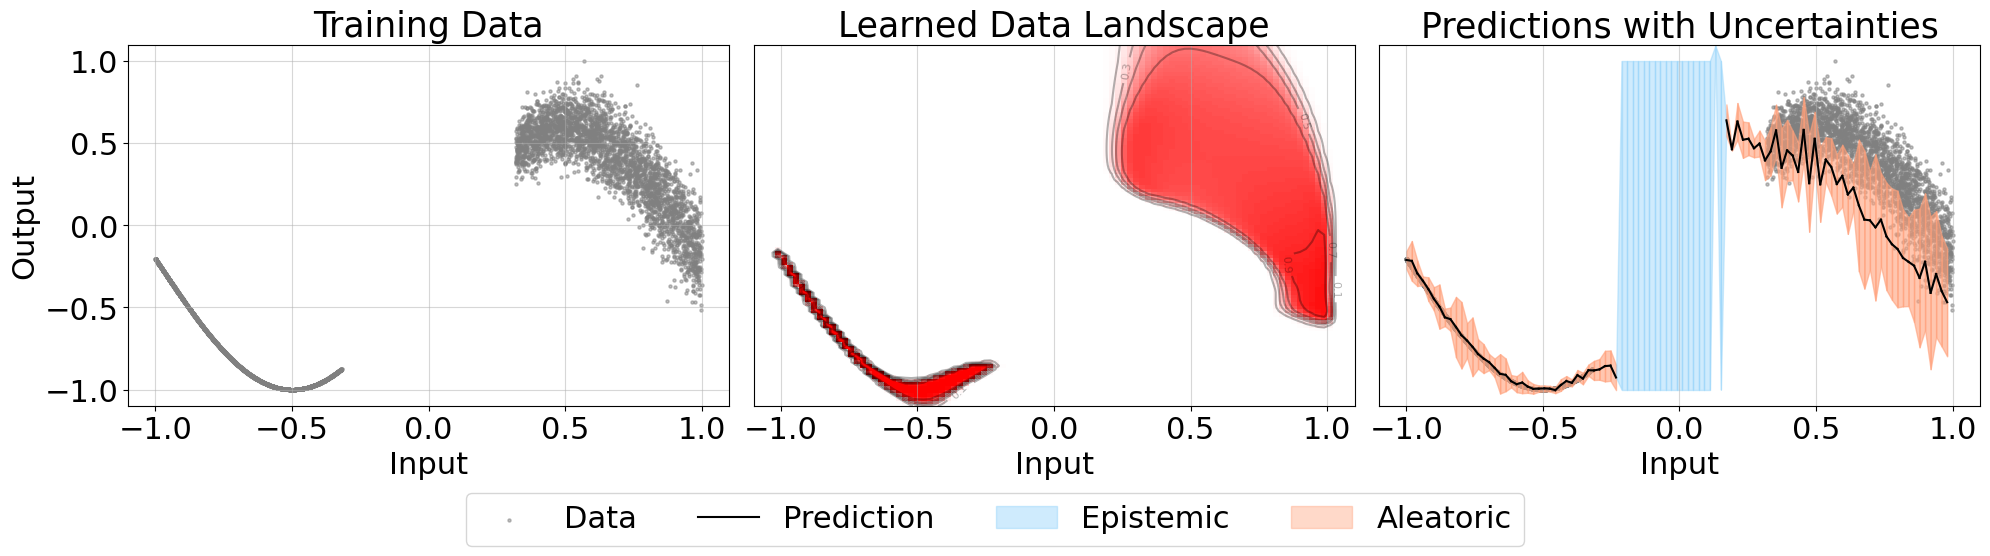

In [60]:
def test_cdrm_model(density_estimator, dataset, device, num_test_points=100):
    """Comprehensive testing and visualization of the cdrm model."""
    # Generate test points
    xs = th.linspace(-1.0, 1.0, num_test_points).reshape(-1, 1).to(device)

    # Get predictions and uncertainties
    predictions, epistemic, aleatoric = predict(
        density_estimator.model, xs, y_range=(-1.10, 1.10),
        num_samples=20, num_steps=30, alpha=0.80, device=device
    )

    # Create figure with three subplots and adjust width ratios to compensate for colorbar
    fig = plt.figure(figsize=(20, 5))
    gs = plt.GridSpec(1, 3, width_ratios=[1, 1, 1])  # Middle plot slightly wider for colorbar
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Common y-axis limits for all plots
    y_lim = (-1.1, 1.1)
    x_lim = (-1.1, 1.1)

    # 1. Input data plot
    ax1.scatter(dataset.x, dataset.y, s=5, c="gray", alpha=0.5, label="Data")
    # ax1.set_xlabel("Input")
    # ax1.set_ylabel("Output")
    ax1.set_ylim(y_lim)
    ax1.set_xlim(x_lim)

    # 2. Density landscape
    x_grid = th.linspace(-1.1, 1.1, 100).to(device)
    y_grid = th.linspace(-1.1, 1.1, 100).to(device)
    X, Y = np.meshgrid(x_grid.cpu().numpy(), y_grid.cpu().numpy(), indexing='xy')

    # Compute density values
    x_flat = th.FloatTensor(X.reshape(-1, 1)).to(device)
    y_flat = th.FloatTensor(Y.reshape(-1, 1)).to(device)

    densities = []
    batch_size = 1000

    with th.no_grad():
        for i in range(0, len(x_flat), batch_size):
            x_batch = x_flat[i:i+batch_size]
            y_batch = y_flat[i:i+batch_size]
            density = density_estimator.model(x_batch, y_batch)
            densities.append(density)

    densities = th.cat(densities, dim=0)
    density_grid = densities.reshape(100, 100).cpu().numpy()

    # Create custom colormap
    colors = [(1, 1, 1), (1, 0.8, 0.8), (1, 0.5, 0.5), (1, 0, 0)]
    cmap = LinearSegmentedColormap.from_list("custom_density", colors, N=100)

    im = ax2.pcolormesh(X, Y, density_grid.T, cmap=cmap, shading='auto')
    # plt.colorbar(im, ax=ax2, label='Density')
    # plt.colorbar(im, ax=ax2)

    # Add contour lines in black with lower alpha for better visibility
    contour_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
    contours = ax2.contour(X, Y, density_grid.T, levels=contour_levels,
                          colors='black', alpha=0.3)
    ax2.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
    # ax2.set_xlabel("Input")
    # ax2.set_ylabel("y")
    ax2.set_ylim(y_lim)
    ax2.set_xlim(x_lim)

    # 3. Predictions with uncertainties
    x_np = xs.cpu().numpy().squeeze()
    pred_np = predictions.cpu().numpy().squeeze()
    eu_np = epistemic.cpu().numpy().squeeze()
    au_np = aleatoric.cpu().numpy().squeeze()

    ax3.scatter(dataset.x, dataset.y, s=5, c="gray", label="Data", alpha=0.5)

    # if either eu_np[i] or eu_np[i+1] is >0.9, then plot in white. Otherwise plot in black.
    for i in range(len(eu_np)-2):
        if eu_np[i] > 0.9 or eu_np[i+1] > 0.9:
            ax3.plot(x_np[i:i+2], pred_np[i:i+2], c="white", alpha=0.0)
            ax3.fill_between(x_np[i:i+2], pred_np[i:i+2] - eu_np[i:i+2], pred_np[i:i+2] + eu_np[i:i+2],
                     color="lightskyblue", alpha=0.4)
            # ax3.fill_between(x_np, pred_np[i:i+2] - au_np[i:i+2], pred_np[i:i+2] + au_np[i:i+2],
            #          color="lightsalmon", alpha=0.6, label="Aleatoric")
        else:
            ax3.plot(x_np[i:i+2], pred_np[i:i+2], c="black")
            ax3.fill_between(x_np[i:i+2], pred_np[i:i+2] - eu_np[i:i+2], pred_np[i:i+2] + eu_np[i:i+2],
                     color="lightskyblue", alpha=0.4)
            ax3.fill_between(x_np[i:i+2], pred_np[i:i+2] - au_np[i:i+2], pred_np[i:i+2] + au_np[i:i+2],
                     color="lightsalmon", alpha=0.6)
    ax3.plot(x_np[-2:-1], pred_np[-2:-1], c="black", label="Prediction")
    # ax3.plot(x_np, pred_np, c="black", label="Prediction")

    ax3.fill_between(x_np[-2:-1], pred_np[-2:-1] - eu_np[-2:-1], pred_np[-2:-1] + eu_np[-2:-1],
                     color="lightskyblue", alpha=0.4, label="Epistemic")
    ax3.fill_between(x_np[-2:-1], pred_np[-2:-1] - au_np[-2:-1], pred_np[-2:-1] + au_np[-2:-1],
                     color="lightsalmon", alpha=0.4, label="Aleatoric")


    ax1.set_title("Training Data", fontsize=25)
    ax2.set_title("Learned Data Landscape", fontsize=25)
    ax3.set_title("Predictions with Uncertainties", fontsize=25)
    # ax3.set_xlabel("Input")
    # ax3.set_ylabel("y")
    # ax3.legend(fontsize=20)
    ax1.grid(True, alpha=0.5)
    ax2.grid(True, alpha=0.5)
    ax3.grid(True, alpha=0.5)
    ax3.set_ylim(y_lim)
    ax3.set_xlim(x_lim)

    ax3.legend(fontsize=18)
    ax1.legend(fontsize=18)

    # set x tick y tick font size
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=22)
    ax3.tick_params(axis='both', which='major', labelsize=22)

    # set y ticks of ax2 and ax3 to none
    ax2.set_yticks([])
    ax3.set_yticks([])

    # set x label y label font size
    ax1.set_xlabel("Input", fontsize=22)
    ax1.set_ylabel('Output', fontsize=22)
    ax2.set_xlabel("Input", fontsize=22)
    # ax2.set_ylabel('y', fontsize=16)
    ax3.set_xlabel("Input", fontsize=22)

    # Remove the individual legends
    ax3.legend().remove()
    ax1.legend().remove()

    # Get all the lines and labels from ax3 for the combined legend
    handles, labels = ax3.get_legend_handles_labels()

    # Add the data point from ax1 if it's not already in the legend
    handles = [handles[0]] + handles[1:]  # Data point should be first
    labels = [labels[0]] + labels[1:]     # "Data" label should be first

    # Create a single legend for the entire figure
    fig.legend(handles, labels,
              loc='center',
              bbox_to_anchor=(0.5, -0.05),  # Position below the subplots
              ncol=4,                       # Arrange items horizontally
              fontsize=22)

    # Adjust the layout to make room for the legend
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)  # Make space for the legend

    plt.tight_layout()
    return fig

# Example usage:

fig = test_cdrm_model(density_estimator, dataset, device)

# save plot to pdf
plt.savefig("density_model_toy_illustration.pdf", bbox_inches='tight')

plt.show()

# Let's try multi-modal data! Train a CDRM on multi-modal dataset

In [62]:
if __name__ == "__main__":
    # Setup
    device = "cuda" if th.cuda.is_available() else "cpu"
    dataset = ToyDataset(10000, split="train")
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # customize a dataset by duplicating every data point and make y = -y
    dataset.x = th.cat((dataset.x, dataset.x), dim=0)
    dataset.y = th.cat((dataset.y, -dataset.y), dim=0)

    # Initialize model
    model_2 = CDRMNet()
    density_estimator_multimodal = CDRM(model_2, device, num_neg_samples=64)

    # Training with progress tracking
    num_epochs = 100
    density_stats = []

    with tqdm(range(num_epochs), desc="Training") as pbar:
        for epoch in pbar:
            epoch_loss = 0
            epoch_pos_density = 0
            epoch_neg_density = 0
            num_batches = 0

            for x, y in dataloader:
                x = x.reshape(-1, 1).to(device)
                y = y.reshape(-1, 1).to(device)
                loss, pos_density, neg_density = density_estimator.train_step(x, y)

                epoch_loss += loss
                epoch_pos_density += pos_density
                epoch_neg_density += neg_density
                num_batches += 1

            avg_loss = epoch_loss / num_batches
            avg_pos_density = epoch_pos_density / num_batches
            avg_neg_density = epoch_neg_density / num_batches

            density_stats.append({
                'pos': avg_pos_density,
                'neg': avg_neg_density
            })

            pbar.set_postfix(
                loss=f"{avg_loss:.4f}",
                pos_density=f"{avg_pos_density:.4f}",
                neg_density=f"{avg_neg_density:.4f}"
            )

Training:   0%|          | 0/100 [00:00<?, ?it/s]

# Test CDRM on multi-modal dataset and plot results

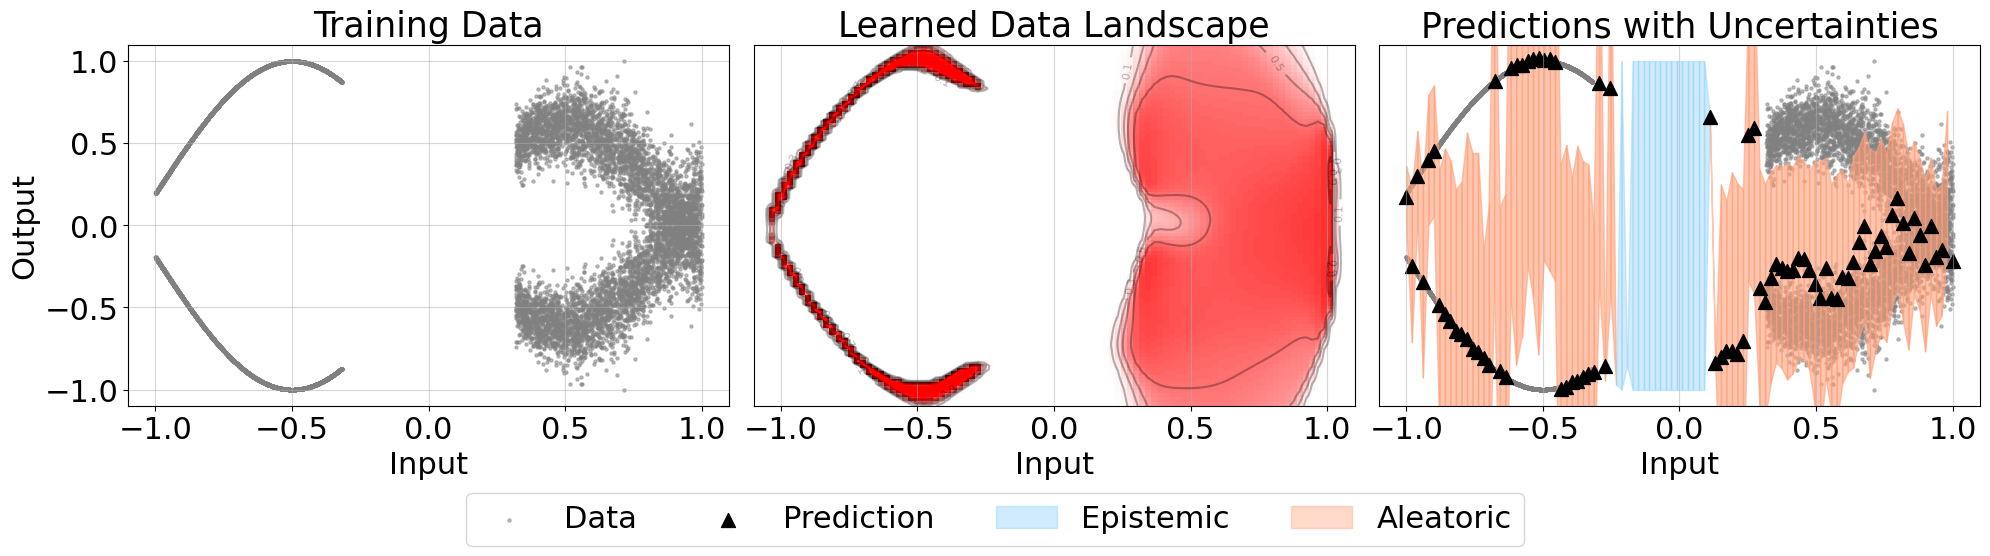

In [68]:
def test_cdrm_model(density_estimator_multimodal, dataset, device, num_test_points=100):
    """Comprehensive testing and visualization of the density model."""
    # Generate test points
    xs = th.linspace(-1.0, 1.0, num_test_points).reshape(-1, 1).to(device)

    # Get predictions and uncertainties
    predictions, epistemic, aleatoric = predict(
        density_estimator.model, xs, y_range=(-1.10, 1.10),
        num_samples=50, num_steps=30, alpha=0.5, device=device
    )

    # Create figure with three subplots and adjust width ratios to compensate for colorbar
    fig = plt.figure(figsize=(20, 5))
    gs = plt.GridSpec(1, 3, width_ratios=[1, 1, 1])  # Middle plot slightly wider for colorbar
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Common y-axis limits for all plots
    y_lim = (-1.1, 1.1)
    x_lim = (-1.1, 1.1)

    # 1. Input data plot
    ax1.scatter(dataset.x, dataset.y, s=5, c="gray", alpha=0.5, label="Data")
    # ax1.set_xlabel("Input")
    # ax1.set_ylabel("Output")
    ax1.set_ylim(y_lim)
    ax1.set_xlim(x_lim)

    # 2. Density landscape
    x_grid = th.linspace(-1.1, 1.1, 100).to(device)
    y_grid = th.linspace(-1.1, 1.1, 100).to(device)
    X, Y = np.meshgrid(x_grid.cpu().numpy(), y_grid.cpu().numpy(), indexing='xy')

    # Compute density values
    x_flat = th.FloatTensor(X.reshape(-1, 1)).to(device)
    y_flat = th.FloatTensor(Y.reshape(-1, 1)).to(device)

    densities = []
    batch_size = 1000

    with th.no_grad():
        for i in range(0, len(x_flat), batch_size):
            x_batch = x_flat[i:i+batch_size]
            y_batch = y_flat[i:i+batch_size]
            density = density_estimator.model(x_batch, y_batch)
            densities.append(density)

    densities = th.cat(densities, dim=0)
    density_grid = densities.reshape(100, 100).cpu().numpy()

    # Create custom colormap
    colors = [(1, 1, 1), (1, 0.8, 0.8), (1, 0.5, 0.5), (1, 0, 0)]
    cmap = LinearSegmentedColormap.from_list("custom_density", colors, N=100)

    im = ax2.pcolormesh(X, Y, density_grid.T, cmap=cmap, shading='auto')
    # plt.colorbar(im, ax=ax2, label='Density')
    # plt.colorbar(im, ax=ax2)

    # Add contour lines in black with lower alpha for better visibility
    contour_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
    contours = ax2.contour(X, Y, density_grid.T, levels=contour_levels,
                          colors='black', alpha=0.3)
    ax2.clabel(contours, inline=True, fontsize=8, fmt='%.1f')
    # ax2.set_xlabel("Input")
    # ax2.set_ylabel("y")
    ax2.set_ylim(y_lim)
    ax2.set_xlim(x_lim)

    # 3. Predictions with uncertainties
    x_np = xs.cpu().numpy().squeeze()
    pred_np = predictions.cpu().numpy().squeeze()
    eu_np = epistemic.cpu().numpy().squeeze()
    au_np = aleatoric.cpu().numpy().squeeze()

    ax3.scatter(dataset.x, dataset.y, s=5, c="gray", label="Data", alpha=0.5)

    # if either eu_np[i] or eu_np[i+1] is >0.9, then plot in white. Otherwise plot in black.
    for i in range(len(eu_np)-2):
        if eu_np[i] > 0.9 or eu_np[i+1] > 0.9:
            # ax3.plot(x_np[i:i+2], pred_np[i:i+2], c="white", alpha=0.0)
            ax3.fill_between(x_np[i:i+2], pred_np[i:i+2] - eu_np[i:i+2], pred_np[i:i+2] + eu_np[i:i+2],
                     color="lightskyblue", alpha=0.4)
            # ax3.fill_between(x_np, pred_np[i:i+2] - au_np[i:i+2], pred_np[i:i+2] + au_np[i:i+2],
            #          color="lightsalmon", alpha=0.6, label="Aleatoric")
        else:
            # ax3.plot(x_np[i:i+2], pred_np[i:i+2], c="black")
            # ax3.fill_between(x_np[i:i+2], pred_np[i:i+2] - eu_np[i:i+2], pred_np[i:i+2] + eu_np[i:i+2],
            #          color="lightskyblue", alpha=0.4)
            ax3.fill_between(x_np[i:i+2], pred_np[i:i+2] - au_np[i:i+2], pred_np[i:i+2] + au_np[i:i+2],
                     color="lightsalmon", alpha=0.6)

    for i in range(len(eu_np)-2):
        if eu_np[i] <= 0.9 and eu_np[i+1] <= 0.9:
          ax3.scatter(x_np[i], pred_np[i], marker="^", s=100, color="black")

    # ax3.plot(x_np[-2:-1], pred_np[-2:-1], c="black", label="Prediction")
    ax3.scatter(x_np[-1], pred_np[-1], marker="^", s=100, color="black", label="Prediction")
    # ax3.plot(x_np, pred_np, c="black", label="Prediction")

    ax3.fill_between(x_np[-2:-1], pred_np[-2:-1] - eu_np[-2:-1], pred_np[-2:-1] + eu_np[-2:-1],
                     color="lightskyblue", alpha=0.4, label="Epistemic")
    ax3.fill_between(x_np[-2:-1], pred_np[-2:-1] - au_np[-2:-1], pred_np[-2:-1] + au_np[-2:-1],
                     color="lightsalmon", alpha=0.4, label="Aleatoric")


    ax1.set_title("Training Data", fontsize=25)
    ax2.set_title("Learned Data Landscape", fontsize=25)
    ax3.set_title("Predictions with Uncertainties", fontsize=25)
    # ax3.set_xlabel("Input")
    # ax3.set_ylabel("y")
    # ax3.legend(fontsize=20)
    ax1.grid(True, alpha=0.5)
    ax2.grid(True, alpha=0.5)
    ax3.grid(True, alpha=0.5)
    ax3.set_ylim(y_lim)
    ax3.set_xlim(x_lim)

    ax3.legend(fontsize=18)
    ax1.legend(fontsize=18)

    # set x tick y tick font size
    ax1.tick_params(axis='both', which='major', labelsize=22)
    ax2.tick_params(axis='both', which='major', labelsize=22)
    ax3.tick_params(axis='both', which='major', labelsize=22)

    # set y ticks of ax2 and ax3 to none
    ax2.set_yticks([])
    ax3.set_yticks([])

    # set x label y label font size
    ax1.set_xlabel("Input", fontsize=22)
    ax1.set_ylabel('Output', fontsize=22)
    ax2.set_xlabel("Input", fontsize=22)
    # ax2.set_ylabel('y', fontsize=16)
    ax3.set_xlabel("Input", fontsize=22)

    # Remove the individual legends
    ax3.legend().remove()
    ax1.legend().remove()

    # Get all the lines and labels from ax3 for the combined legend
    handles, labels = ax3.get_legend_handles_labels()

    # Add the data point from ax1 if it's not already in the legend
    handles = [handles[0]] + handles[1:]  # Data point should be first
    labels = [labels[0]] + labels[1:]     # "Data" label should be first

    # Create a single legend for the entire figure
    fig.legend(handles, labels,
              loc='center',
              bbox_to_anchor=(0.5, -0.05),  # Position below the subplots
              ncol=4,                       # Arrange items horizontally
              fontsize=22)

    # Adjust the layout to make room for the legend
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.2)  # Make space for the legend

    plt.tight_layout()
    return fig

# Example usage:

fig = test_cdrm_model(density_estimator_multimodal, dataset, device)

# save plot to pdf
plt.savefig("density_model_multimodal_illustration.pdf", bbox_inches='tight')

plt.show()